# 1. Importación de librerías y carga de datos

In [1]:
SCALED=False
STANDARIZED=False

In [2]:
#from google.colab import drive

import haversine as hs
import pandas as pd
import numpy as np
import pickle
import time
import os

import tensorflow as tf
tf.config.run_functions_eagerly(True)
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import LSTM, GRU, Dense, Reshape, Dropout, Bidirectional, \
  RepeatVector, TimeDistributed, Conv1D, MaxPooling1D, Flatten, ConvLSTM2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from haversine import inverse_haversine, Direction
from attention import Attention

if SCALED:
    from sklearn.preprocessing import MinMaxScaler
elif STANDARIZED:
    from sklearn.preprocessing import StandardScaler

from shapely import geometry
import geopy
import geopy.distance
import math

import matplotlib.pyplot as plt

from codecarbon import EmissionsTracker

C:\Users\sandr\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [3]:
# Hacemos el resultado reproducible
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

# Declaramos el tipo de float, en este caso float64
tf.keras.backend.set_floatx('float64')

In [4]:
df = pd.read_csv('positions.csv')

columns = ['time(s)', 'vehicle_id']
df = df[columns]
df = df.sort_values(by=['vehicle_id', 'time(s)'])
df.head()

,time(s),vehicle_id
1063,11.0,2
1168,12.0,2
1273,13.0,2
1378,14.0,2
1483,15.0,2


In [5]:
# Load MinMaxScaler for target variables
if SCALED:
    MINMAXSCALER_FILE = './minmaxscaler.pkl'#os.path.join("TFM", "implementation",
                             #"data_preparation", "minmaxscaler.pkl")
    with open(MINMAXSCALER_FILE, 'rb') as f_minmaxscaler:
        minmaxscaler = pickle.load(f_minmaxscaler)
if STANDARIZED:
    TARGETS_STAND_FILE = './' #os.path.join("TFM", "implementation",
                                     #"data_preparation", "targets_stand.pkl")
    with open(TARGETS_STAND_FILE, 'rb') as f_scaler:
        standscaler_targets = pickle.load(f_scaler)

In [6]:
# Load training dataset
if SCALED:
    DATASET_TRAIN = os.path.join('./',
                               "ventanas_no_coincidentes_train_val_scaled.npz")
elif STANDARIZED:
    DATASET_TRAIN = os.path.join('./',
                               "ventanas_no_coincidentes_train_val_stand.npz")
else:
    DATASET_TRAIN = os.path.join('./',
                               "ventanas_no_coincidentes_train_val.npz")
    
npzfile = np.load(DATASET_TRAIN)
X_train = npzfile['X_train']
X_val = npzfile['X_val']
y_train = npzfile['y_train']
y_val = npzfile['y_val']
print("X_train: {}  y_train: {}\nX_val: {}  y_val: {}"
      .format(X_train.shape, y_train.shape, X_val.shape, y_val.shape))

# Load testing dataset
if SCALED:
    DATASET_TEST = os.path.join('./',
                              "ventanas_no_coincidentes_test_scaled.npz")
elif STANDARIZED:
    DATASET_TEST = os.path.join('./',
                              "ventanas_no_coincidentes_test_stand.npz")
else:
    DATASET_TEST = os.path.join('./',
                              "ventanas_no_coincidentes_test.npz")
npzfile = np.load(DATASET_TEST)
X_test = npzfile['X_test']
y_test = npzfile['y_test']
print("X_test: {}  y_test: {}".format(X_test.shape, y_test.shape))

# Load testing vehicle ids list
VEHICLE_IDS_FILE = os.path.join('./', "vehicle_ids.pkl")
with open(VEHICLE_IDS_FILE, 'rb') as f_vehicle_ids:
    vehicle_ids = pickle.load(f_vehicle_ids)
print("Vehicle_ids: {}".format(len(vehicle_ids)))

X_train: (216737, 20, 5)  y_train: (216737, 5, 5)
X_val: (92888, 20, 5)  y_val: (92888, 5, 5)
X_test: (2140, 20, 5)  y_test: (2140, 5, 5)
Vehicle_ids: 2140


In [7]:
# Load dataset with vehicles dimensions
DATASET_DIM = os.path.join('./', "dimensions.csv")
df_dim = pd.read_csv(DATASET_DIM)
df_dim = df_dim[['vehicle_id', 'length', 'width']]
df_dim.head()

,vehicle_id,length,width
0,2,5.0,1.8
1,3,5.0,1.8
2,4,2.2,0.9
3,5,5.0,1.8
4,6,5.0,1.8


In [8]:
# Load dataset with vehicles colision
#DATASET_COL = os.path.join('./', "collisions_1k.csv")
df_col = pd.read_csv('collisions_1k.csv')
df_col = df_col[['vehicle_id', 'victim_id']].astype(int)
df_col.head()

,vehicle_id,victim_id
0,121,103
1,158,113
2,197,165
3,193,230
4,207,122


In [9]:
# Load dataset with vehicles no-colision
#DATASET_NOCOL = os.path.join('./', "no_collisions_1k.csv")
df_nocol = pd.read_csv('no_collisions_1k.csv')
df_nocol = df_nocol[['v1', 'v2']]
df_nocol.head()

,v1,v2
0,800,770
1,4115,4132
2,2054,2006
3,736,782
4,1291,1262


In [10]:
df_col.shape

(1000, 2)

In [11]:
df_nocol.shape

(1000, 2)

# 2. Generación y entrenamiento de los modelos

In [12]:
#if SCALED:
#    MODELS_FOLDER = os.path.join("TFM", "implementation", "models", "scaled")
#elif STANDARIZED:
#    MODELS_FOLDER = os.path.join("TFM", "implementation", "models", "standarized")
#else:
#    MODELS_FOLDER = os.path.join("TFM", "implementation", "models", "real")
    
MODELS_FOLDER = './'

In [13]:
# Windows parameters
INPUT_WIDTH=20
OUTPUT_WIDTH=5
OFFSET_WIDTH=0

# Input and output columns
INPUT_COL = ['latitude(m)', 'longitude(m)', 'heading', 'speed(m/s)', 'acceleration(m/s²)']
OUTPUT_COL = ['latitude(m)', 'longitude(m)', 'heading', 'speed(m/s)', 'acceleration(m/s²)']

# Training parameters
EPOCHS= 2
BATCH_SIZE=64
PATIENCE=5
REDUCELR=0.2
  
def physics_loss(y_true, y_pred):

    # Para facilitar el cálculo, hacemos un reshape de y_true para juntar las 64 muestras (batch_size)
    a,b,c = tf.shape(y_true)
    y_true = tf.reshape(y_true, [a.numpy()*b.numpy(),c.numpy()])
    y_pred = tf.reshape(y_pred, [a.numpy()*b.numpy(),c.numpy()])
    
    
    # Calculamos velocidades y aceleraciones
    vx = tf.gather(y_true,[3],axis=1) * tf.math.cos(tf.gather(y_true,[2],axis=1))
    vy = tf.gather(y_true,[3],axis=1) * tf.math.sin(tf.gather(y_true,[2],axis=1))
    ax = tf.gather(y_true,[4],axis=1) * tf.math.cos(tf.gather(y_true,[2],axis=1))
    ay = tf.gather(y_true,[4],axis=1) * tf.math.sin(tf.gather(y_true,[2],axis=1))

    # Aplicamos las ecuaciones del movimiento para obtener la distancia recorrida en metros
    dist_lat_m = vy + ay/2
    dist_lon_m = vx + ax/2

    # Pasamos la distancia recorrida en metros a las distancias en latitud longitud
    dist_lat = (dist_lat_m/6371000)*(180/math.pi)
    dist_lon = (dist_lon_m/6371000)*(180/math.pi) / tf.math.cos(tf.gather(y_true,[0],axis=1) * math.pi/180)

    # Calculamos las nuevas latitud y longitud
    pred_latitude = tf.gather(y_true,[0],axis=1) + dist_lat
    pred_longitude = tf.gather(y_true,[1],axis=1) + dist_lon
    
    # La pérdida será reducir la distancia entre las predichas y las calculadas físicamente
    loss = tf.reduce_mean(tf.square(pred_latitude -tf.gather(y_pred,[0],axis=1)) 
                          + tf.square(pred_longitude -tf.gather(y_pred,[1],axis=1)))
    
    
    return loss


def compile_and_fit(model, X_train, y_train, X_val, y_val, folder, epochs=20,
                    batch_size=32, patience=2, learning_rate=0.001, reduce_lr=0):
    tracker = EmissionsTracker(log_level="error")
    callback_list = []

    # Return best model that minimize loss function
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=patience*2, mode='min',
        restore_best_weights=True)
    callback_list.append(early_stopping)

    # Save best model that minimize loss function
    checkpoint_file = os.path.join(folder, 'model_saved.hdf5')
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_file, monitor='val_loss', mode="min",
        save_best_only=True, verbose=0)
    callback_list.append(checkpoint)
  
    if reduce_lr != 0:
        # Reduce learning rate to minimize loss function
        reduce_learningrate = ReduceLROnPlateau(
            monitor='val_loss', patience=patience, mode='min', factor=reduce_lr)
        callback_list.append(reduce_learningrate)

    model.compile(loss=physics_loss,#tf.keras.losses.MeanSquaredError(),
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    tracker.start()
    start_time = time.time()
    print('X_train.shape:', X_train.shape)
    print('y_train.shape:', y_train.shape)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                      validation_data=(X_val, y_val),
                      callbacks=callback_list)
    total_time = time.time() - start_time
    emissions = tracker.stop()

    # Save fit history
    history_pickle = os.path.join(folder, 'history.pkl')
    pickle.dump(history.history, open(history_pickle, 'wb'))

    # Print and write fit statistics
    min_val_loss = min(history.history['val_loss'])
    best_model_index = history.history['val_loss'].index(min_val_loss)
    print("\nTraining Loss (MSE): {}".format(history.history['loss'][best_model_index]))
    print("Validation Loss (MSE): {}".format(history.history['val_loss'][best_model_index]))
    print("Training MAE: {}".format(history.history['mean_absolute_error'][best_model_index]))
    print("Validation MAE: {}".format(history.history['val_mean_absolute_error'][best_model_index]))
    print("Execution time (s): {}".format(total_time))
    print("Emissions (kg): {}\n".format(emissions))
    stats_file = os.path.join(folder, "stats.txt")
    with open(stats_file, 'w') as f_stats:
        f_stats.write("Training Loss (MSE): {}\n".format(history.history['loss'][best_model_index]))
        f_stats.write("Validation Loss (MSE): {}\n".format(history.history['val_loss'][best_model_index]))
        f_stats.write("Training MAE: {}\n".format(history.history['mean_absolute_error'][best_model_index]))
        f_stats.write("Validation MAE: {}\n".format(history.history['val_mean_absolute_error'][best_model_index]))
        f_stats.write("Execution time (s): {}\n".format(total_time))
        f_stats.write("Emissions (kg): {}\n".format(emissions))

    return history


def plot_history(history, start=None, end=None):
    train_loss = history['loss'][start:end]
    val_loss = history['val_loss'][start:end]
    train_mae = history['mean_absolute_error'][start:end]
    test_mae = history['val_mean_absolute_error'][start:end]

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].plot(train_loss, label="Train")
    ax[0].plot(val_loss, label="Validation")
    ax[0].set_title("Training and Validation loss")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend()

    ax[1].plot(train_mae, label="Train")
    ax[1].plot(test_mae, label="Validation")
    ax[1].set_title("Training and Validation MAE")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Mean Absolute Error")
    ax[1].legend()

    plt.show()


def model_predictions(model, X_test, y_test, y_test_UTF):
    def calculate_haversine(coord1, coord2):
        return hs.haversine(coord1, coord2, unit=hs.Unit.METERS)

    y_pred = y_test_UTF#model.predict(X_test)
    if SCALED:
        y_pred = minmaxscaler.inverse_transform(y_pred.reshape(-1, 2))
    elif STANDARIZED:
        y_pred = standscaler_targets.inverse_transform(y_pred.reshape(-1, 2))
    y_pred = y_pred.reshape(-1, 4)

    if SCALED:
        y_test = minmaxscaler.inverse_transform(y_test.reshape(-1, 2))
    elif STANDARIZED:
        y_test = standscaler_targets.inverse_transform(y_test.reshape(-1, 2))
    y_test = y_test.reshape(-1, 5)

    df_y_pred = pd.DataFrame(
        y_pred, columns=['latitude(pred)', 'longitude(pred)','heading(pred)', 'speed(m/s)(pred)'])
    df_y_test = pd.DataFrame(y_test, columns=['latitude', 'longitude', 'heading', 'speed(m/s)', 'acceleration(m/s²)'])
    df_pred = pd.concat([df_y_pred, df_y_test], axis=1)

    distance = df_pred.apply(
        lambda row: calculate_haversine((row['latitude(pred)'], row['longitude(pred)']),
                                        (row['latitude'], row['longitude'])), axis=1)
    df_pred['distance(m)'] = distance

    return df_pred

In [34]:
from filterpy.kalman import UnscentedKalmanFilter, MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise

def UKF(X_test):

    y_pred = model.predict(X_test, verbose=0)

    # Define UKF process and measurement functions
    def process_model(x, dt):
        # Simple kinematic model: x' = x + v * dt (transformado metros a lat lon (grados))
        x[0] += ((x[3] * np.sin(x[2]) * dt)/6371000)*(180/math.pi)
        x[1] += ((x[3] * np.cos(x[2]) * dt)/6371000)*(180/math.pi) / math.cos(x[0] * math.pi/180)

        return x

    def measurement_model(x):
        return np.array([x[0], x[1]])

    y_test_UKF = []

    for y in y_pred:

        X_initial = [x[0:4] for x in y]

        # Initialize UKF
        initial_state = X_initial[0] # Initial state
        ukf = UnscentedKalmanFilter(dim_x=4, dim_z=2, dt=1.0, fx=process_model, hx=measurement_model,
                                    points=MerweScaledSigmaPoints(4, alpha=0.1, beta=2., kappa=1.))
        ukf.x = initial_state
        ukf.P *= 0.1  # Initial uncertainty
        ukf.R *= 10  # Measurement noise
        ukf.Q = Q_discrete_white_noise(dim=4, dt=1.0, var=0.01)  # Process noise

        # Initialize arrays to store estimated states
        estimated_states = np.zeros((len(X_initial), 4))

        # Perform UKF prediction and update
        for i in range(len(X_initial)):
            #print(np.array([[x[0] for x in X_initial][i], [x[1] for x in X_initial][i]]))
            ukf.predict()
            ukf.update(np.array([[x[0] for x in X_initial][i], [x[1] for x in X_initial][i]]))
            estimated_states[i] = ukf.x

        y_test_UKF.append(np.array(estimated_states))

    y_test_UKF = np.array(y_test_UKF)
    return y_test_UKF

In [35]:
import warnings
warnings.filterwarnings('ignore')

def bearing_calc(a_lat, a_lon, b_lat, b_lon): # a previous position b current position
    rlat1 = math.radians(a_lat)
    rlon1 = math.radians(a_lon)
    rlat2 = math.radians(b_lat)
    rlon2 = math.radians(b_lon)
    dlon = math.radians(b_lon - a_lon)
    b = math.atan2(
      math.sin(dlon)*math.cos(rlat2),
      math.cos(rlat1)*math.sin(rlat2)-math.sin(rlat1)*math.cos(rlat2)*math.cos(dlon))  # bearing calc
    bd = math.degrees(b)
    br, bn = divmod(bd + 360, 360)  # the bearing remainder and final bearing
    return bn


# To get a rotated rectangle at a bearing, you need to get the points of the the recatangle at that bearing
def get_rotated_points(coordinates, bearing, width, length):
    start = geopy.Point(coordinates)
    width = width/1000
    length = length/1000
    rectlength = geopy.distance.distance(kilometers=length)
    rectwidth = geopy.distance.distance(kilometers=width)
    halfwidth = geopy.distance.distance(kilometers=width/2)
    halflength = geopy.distance.distance(kilometers=length/2)

    pointAB = halflength.destination(point=start, bearing=bearing)
    pointA = halfwidth.destination(point=pointAB, bearing=0 - bearing)
    pointB = rectwidth.destination(point=pointA, bearing=180 - bearing)
    pointC = rectlength.destination(point=pointB, bearing=bearing - 180)
    pointD = rectwidth.destination(point=pointC, bearing=0 - bearing)

    points = []
    for point in [pointA, pointB, pointC, pointD]:
        coords = (point.latitude, point.longitude)
        points.append(coords)

    return points

def get_colision(v1_id, v2_id, X_test_v1, X_test_v2, dimensions, model):
    colision = 0

    #y_pred_v1 = model.predict(X_test_v1.reshape(1, 20, 5), verbose=0)
    y_pred_v1 = UKF(X_test_v1.reshape(1, 20, 5))
    if SCALED:
        y_pred_v1 = minmaxscaler.inverse_transform(y_pred_v1.reshape(-1, 2))
    elif STANDARIZED:
        y_pred_v1 = standscaler_targets.inverse_transform(y_pred_v1.reshape(-1, 2))
    y_pred_v1 = y_pred_v1.reshape(-1, 4)
    v1_coord_5 = y_pred_v1[-1]
  # v1_coord_4 = y_pred_v1[-2]

    v1_length = dimensions[dimensions['vehicle_id'] == v1_id].iloc[0, 1]
    v1_width = dimensions[dimensions['vehicle_id'] == v1_id].iloc[0, 2]

  # v1_bearing = bearing_calc(v1_coord_4[0], v1_coord_4[1],
  #                           v1_coord_5[0], v1_coord_5[1])
    v1_points = get_rotated_points(tuple(v1_coord_5[:2]), v1_coord_5[-1],
                                 v1_width, v1_length)
    polygon1 = geometry.Polygon(v1_points)

    #y_pred_v2 = model.predict(X_test_v2.reshape(1, 20, 5), verbose=0)
    y_pred_v2 = UKF(X_test_v2.reshape(1, 20, 5))
    if SCALED:
        y_pred_v2 = minmaxscaler.inverse_transform(y_pred_v2.reshape(-1, 5))
    elif STANDARIZED:
        y_pred_v2 = standscaler_targets.inverse_transform(y_pred_v2.reshape(-1, 2))
    y_pred_v2 = y_pred_v2.reshape(-1, 4)
    v2_coord_5 = y_pred_v2[-1]
  # v2_coord_4 = y_pred_v2[-2]

    v2_length = dimensions[dimensions['vehicle_id'] == v2_id].iloc[0, 1]
    v2_width = dimensions[dimensions['vehicle_id'] == v2_id].iloc[0, 2]

  # v2_bearing = bearing_calc(v2_coord_4[0], v2_coord_4[1],
  #                           v2_coord_5[0], v2_coord_5[1])
    v2_points = get_rotated_points(tuple(v2_coord_5[:2]), v2_coord_5[-1],
                                 v2_width, v2_length)
    polygon2 = geometry.Polygon(v2_points)

    if polygon1.intersection(polygon2).area > 0.0:
        colision = 1
  
    return colision

def get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim,
                metrics_file):
    total_colision = 0
    total_no_colision = 0

    true_positive = 0
    false_negative = 0
    false_positive = 0
    true_negative = 0

    # Vehiculos que coinciden y colisionan
    print('coinciden y colisionan:', df_col.shape[0])
    for i in range(df_col.shape[0]):
        v1_id = df_col.iloc[i, 0]
        v2_id = df_col.iloc[i, 1]

        v1_ts_set = set(df[df['vehicle_id'] == v1_id].iloc[-5:, 0])
        v2_ts_set = set(df[df['vehicle_id'] == v2_id].iloc[-5:, 0])
        intersection = sorted(list(v1_ts_set.intersection(v2_ts_set)))
        if len(intersection) >= 2:
            total_colision += 1
            v1_index = vehicle_ids.index(v1_id)
            v2_index = vehicle_ids.index(v2_id)
            if get_colision(v1_id, v2_id, X_test[v1_index], X_test[v2_index], df_dim, model):
                true_positive += 1
            else:
                false_negative += 1

  # Vehiculos que coinciden pero no colisionan
    print('coinciden pero no colisionan:', df_nocol.shape[0])
    for i in range(df_nocol.shape[0]):
        v1_id = df_nocol.iloc[i, 0]
        v2_id = df_nocol.iloc[i, 1]

        v1_ts_set = set(df[df['vehicle_id'] == v1_id].iloc[-5:, 0])
        v2_ts_set = set(df[df['vehicle_id'] == v2_id].iloc[-5:, 0])
        intersection = sorted(list(v1_ts_set.intersection(v2_ts_set)))
        if len(intersection) >= 2:
            total_no_colision += 1
            v1_index = vehicle_ids.index(v1_id)
            v2_index = vehicle_ids.index(v2_id)
            if get_colision(v1_id, v2_id, X_test[v1_index], X_test[v2_index], df_dim, model):
                false_positive += 1
            else:
                true_negative += 1


    accuracy = (true_positive+true_negative)/(true_positive+false_positive+false_negative+true_negative)
    precision = true_positive/(true_positive+false_positive) if (true_positive+false_positive) != 0 else 0
    recall = true_positive/(true_positive+false_negative) if (true_positive+false_negative) != 0 else 0
    F1_score = 2*(recall*precision)/(recall+precision) if (recall+precision) != 0 else 0
    specificity = true_negative/(true_negative+false_positive) if (true_negative+false_positive) != 0 else 0

    with open(metrics_file, 'w') as f_metrics:
        f_metrics.write("Total colision: {}\n".format(total_colision))
        f_metrics.write("TP: {}\n".format(true_positive))
        f_metrics.write("FN: {}\n".format(false_negative))
        f_metrics.write("Total no colision: {}\n".format(total_no_colision))
        f_metrics.write("FP: {}\n".format(false_positive))
        f_metrics.write("TN: {}\n\n".format(true_negative))
        f_metrics.write("Accuracy: {}\n".format(accuracy))
        f_metrics.write("Precision: {}\n".format(precision))
        f_metrics.write("Recall: {}\n".format(recall))
        f_metrics.write("F1 Score: {}\n".format(F1_score))
        f_metrics.write("Specificity: {}\n".format(specificity))


    print("Total colision: {}".format(total_colision))
    print("TP: {}".format(true_positive))
    print("FN: {}".format(false_negative))
    print("Total no colision: {}".format(total_no_colision))
    print("FP: {}".format(false_positive))
    print("TN: {}".format(true_negative))
    print()
    print("Accuracy: {}".format(accuracy))
    print("Precision: {}".format(precision))
    print("Recall: {}".format(recall))
    print("F1 Score: {}".format(F1_score))
    print("Specificity: {}".format(specificity))

## 2.1. PINNs

In [37]:
def make_lstm_model(units, in_steps, out_steps, in_features, out_features):
    lstm_model = Sequential()

    # Shape [batch, time, in_features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    lstm_model.add(LSTM(
      units, input_shape=(in_steps, in_features)))

    # Shape => [batch, out_steps*out_features].
    lstm_model.add(Dense(out_steps*out_features))

    # Shape => [batch, out_steps, out_features].
    lstm_model.add(Reshape([out_steps, out_features]))

    lstm_model.summary()

    return lstm_model

### 2.1.1. Modelo LSTM (64 unidades)

#### 2.1.1.1. Creación y entrenamiento de la red

In [38]:
# Define loss function
def physics_loss(y_true, y_pred):

    # Para facilitar el cálculo, hacemos un reshape de y_true para juntar las 64 muestras (batch_size)
    a,b,c = tf.shape(y_true)
    y_true = tf.reshape(y_true, [a.numpy()*b.numpy(),c.numpy()])
    y_pred = tf.reshape(y_pred, [a.numpy()*b.numpy(),c.numpy()])
    
    
    # Calculamos velocidades y aceleraciones
    vx = tf.gather(y_true,[3],axis=1) * tf.math.cos(tf.gather(y_true,[2],axis=1))
    vy = tf.gather(y_true,[3],axis=1) * tf.math.sin(tf.gather(y_true,[2],axis=1))
    ax = tf.gather(y_true,[4],axis=1) * tf.math.cos(tf.gather(y_true,[2],axis=1))
    ay = tf.gather(y_true,[4],axis=1) * tf.math.sin(tf.gather(y_true,[2],axis=1))

    # Aplicamos las ecuaciones del movimiento para obtener la distancia recorrida en metros
    dist_lat_m = vy + ay/2
    dist_lon_m = vx + ax/2

    # Pasamos la distancia recorrida en metros a las distancias en latitud longitud
    dist_lat = (dist_lat_m/6371000)*(180/math.pi)
    dist_lon = (dist_lon_m/6371000)*(180/math.pi) / tf.math.cos(tf.gather(y_true,[0],axis=1) * math.pi/180)

    # Calculamos las nuevas latitud y longitud
    pred_latitude = tf.gather(y_true,[0],axis=1) + dist_lat
    pred_longitude = tf.gather(y_true,[1],axis=1) + dist_lon
    
    # La pérdida será reducir la distancia entre las predichas y las calculadas físicamente
    loss = tf.reduce_mean(tf.square(pred_latitude -tf.gather(y_pred,[0],axis=1)) 
          + tf.square(pred_longitude -tf.gather(y_pred,[1],axis=1)))
    return loss

In [39]:
# Load fitted model 
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple", "PINN_LSTM_64units")
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE, compile=False) #https://stackoverflow.com/questions/48373845/loading-model-with-custom-loss-keras

In [40]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple", "UKF_PINN_LSTM_64units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

#### 2.1.1.2. Predicción de la red

In [41]:
df_pred = model_predictions(model, X_test, y_test, UKF(X_test))
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

Distance(m): [24.21698210375716, 333.18512117910444]


,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
0,41.390499,2.165066,0.632110,1.021852,41.390257,2.164511,68.785242,0.000000,0.000000,53.541688
1,41.390504,2.165074,0.632109,1.021851,41.390257,2.164511,68.785242,0.000000,0.000000,54.409599
2,41.390509,2.165079,0.632109,1.021851,41.390257,2.164511,68.785242,0.000000,0.000000,55.057387
3,41.390513,2.165088,0.632109,1.021851,41.390257,2.164511,68.785242,0.000000,0.000000,55.949808
4,41.390518,2.165096,0.632109,1.021851,41.390257,2.164511,68.785242,0.000000,0.000000,56.827806
...,...,...,...,...,...,...,...,...,...,...
10695,41.390755,2.165137,0.632114,1.021860,41.390307,2.164345,134.672259,8.662768,0.125779,82.746023
10696,41.390760,2.165144,0.632114,1.021860,41.390253,2.164419,134.672259,8.694597,0.031829,82.688609
10697,41.390765,2.165148,0.632114,1.021860,41.390258,2.164513,63.636569,8.779438,0.084841,77.406219
10698,41.390770,2.165157,0.632113,1.021860,41.390305,2.164595,51.815575,8.671826,-0.107612,69.755087


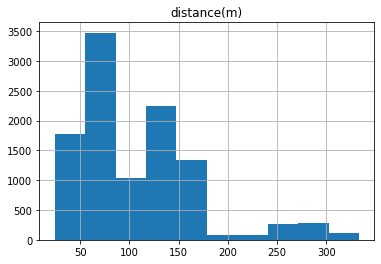

In [42]:
df_pred.hist('distance(m)')
plt.show()

In [43]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
    if i%5 == 0:
        list_1seg[i] = True
    elif i%5 == 1:
        list_2seg[i] = True
    elif i%5 == 2:
        list_3seg[i] = True
    elif i%5 == 3:
        list_4seg[i] = True
    elif i%5 == 4:
        list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [44]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [24.21698210375716, 329.5147242221054]
Segundo 2: [30.15767259615381, 330.94836771318404]
Segundo 3: [29.873233766293453, 332.1610296932802]
Segundo 4: [30.703240225486418, 333.18512117910444]
Segundo 5: [27.94944422188959, 332.8269342213032]


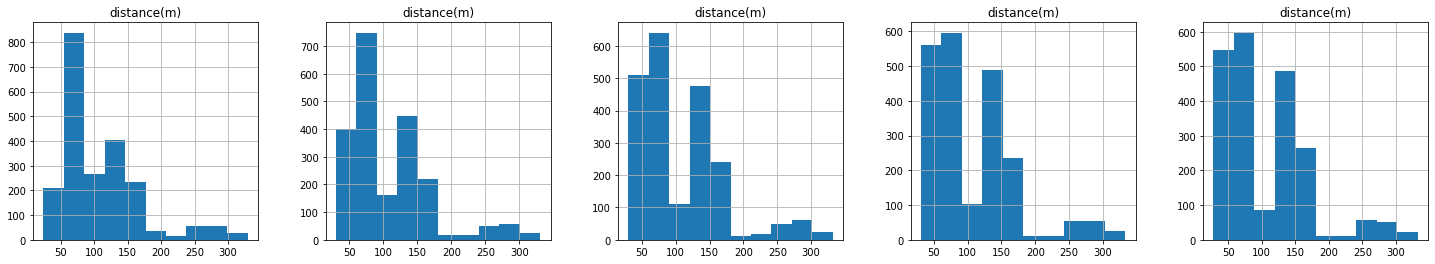

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [46]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000
mean,41.390604,2.165104,0.632118,1.021855,41.390721,2.164702,143.515413,4.582792,0.338341,108.642946
std,0.000214,0.000049,0.000008,0.000009,0.000746,0.001025,94.998202,3.703825,1.433489,57.729709
min,41.389713,2.164888,0.632109,1.021800,41.388935,2.161518,34.502433,0.000000,-8.300889,24.216982
25%,41.390409,2.165073,0.632113,1.021852,41.390207,2.164287,47.451700,1.535193,-0.092715,67.053608
50%,41.390738,2.165133,0.632115,1.021860,41.390346,2.164437,134.672259,4.120417,0.247167,88.005018
75%,41.390764,2.165139,0.632124,1.021860,41.391149,2.165170,220.113866,6.972255,1.124182,133.651513
max,41.390779,2.165141,0.632157,1.021865,41.393017,2.166983,319.056928,17.326185,5.893669,329.514724


In [47]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000
mean,41.390609,2.165112,0.632118,1.021855,41.390723,2.164719,142.891052,4.959864,0.377072,108.442609
std,0.000214,0.000048,0.000008,0.000009,0.000739,0.001033,95.305879,3.549060,1.473157,58.502678
min,41.389718,2.164898,0.632109,1.021801,41.388988,2.161605,7.398825,0.000000,-7.609870,30.157673
25%,41.390414,2.165081,0.632113,1.021852,41.390237,2.164347,47.451700,2.090106,-0.108798,64.729983
50%,41.390743,2.165140,0.632115,1.021860,41.390327,2.164481,134.672259,4.859161,0.382035,87.624699
75%,41.390769,2.165146,0.632124,1.021860,41.391151,2.165151,222.774459,7.166618,1.248187,135.238149
max,41.390784,2.165148,0.632157,1.021865,41.393005,2.166985,319.056928,17.299837,5.736222,330.948368


In [48]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000
mean,41.390614,2.165117,0.632118,1.021855,41.390726,2.164737,142.542545,5.454671,0.494807,108.055922
std,0.000214,0.000048,0.000008,0.000009,0.000732,0.001043,95.846327,3.440639,1.532553,59.583976
min,41.389722,2.164905,0.632109,1.021800,41.389032,2.161694,23.673287,0.000000,-10.000000,29.873234
25%,41.390419,2.165086,0.632113,1.021851,41.390243,2.164406,47.451700,2.726781,-0.056402,61.403399
50%,41.390748,2.165145,0.632115,1.021859,41.390321,2.164511,134.672259,5.682068,0.480859,87.135688
75%,41.390775,2.165151,0.632123,1.021860,41.391166,2.165131,223.500684,7.514099,1.498910,138.078653
max,41.390789,2.165152,0.632156,1.021864,41.392992,2.166984,319.056928,17.551783,5.927003,332.161030


In [49]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000
mean,41.390619,2.165125,0.632118,1.021854,41.390731,2.164753,140.709594,5.803700,0.349029,107.611293
std,0.000214,0.000047,0.000008,0.000009,0.000722,0.001052,97.153725,3.462879,1.692382,60.814783
min,41.389727,2.164915,0.632108,1.021800,41.389076,2.161813,2.967874,0.000000,-9.546519,30.703240
25%,41.390424,2.165094,0.632112,1.021851,41.390256,2.164468,46.850401,3.450400,-0.159490,57.798711
50%,41.390753,2.165153,0.632115,1.021859,41.390325,2.164522,121.289075,6.258995,0.365722,86.406096
75%,41.390780,2.165159,0.632123,1.021860,41.391159,2.165088,223.899024,7.801315,1.393101,141.829548
max,41.390794,2.165161,0.632156,1.021864,41.392983,2.166965,357.952123,16.804944,5.774178,333.185121


In [50]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000
mean,41.390624,2.165133,0.632118,1.021854,41.390737,2.164766,143.245644,5.912547,0.127520,106.970947
std,0.000214,0.000047,0.000008,0.000009,0.000709,0.001062,99.687224,3.386663,1.897610,61.956379
min,41.389731,2.164925,0.632108,1.021800,41.389112,2.161936,3.194324,0.000000,-10.000000,27.949444
25%,41.390429,2.165103,0.632112,1.021851,41.390276,2.164511,46.445310,3.901270,-0.264314,56.909124
50%,41.390758,2.165161,0.632114,1.021859,41.390343,2.164571,127.399323,6.575107,0.192974,86.463064
75%,41.390785,2.165167,0.632123,1.021859,41.391135,2.165048,223.899024,7.953079,1.093864,143.682166
max,41.390800,2.165168,0.632156,1.021864,41.392960,2.166965,359.775293,16.031603,5.809681,332.826934


#### 2.1.1.3. Métricas del modelo

In [52]:
# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim, METRICS_FILE)

coinciden y colisionan: 1000
coinciden pero no colisionan: 1000
Total colision: 1000
TP: 110
FN: 890
Total no colision: 1000
FP: 109
TN: 891

Accuracy: 0.5005
Precision: 0.502283105022831
Recall: 0.11
F1 Score: 0.1804757998359311
Specificity: 0.891
